In [1]:
import xclim
import xarray as xr
import cftime
import xclim.sdba as sdba
import dask
import glob

from dask.distributed import LocalCluster, Client

In [5]:
cluster = LocalCluster()

2025-02-27 13:42:48,087 - distributed.scheduler - WARNING - Worker failed to heartbeat for 530s; attempting restart: <WorkerState 'tcp://127.0.0.1:53630', name: 3, status: running, memory: 0, processing: 0>
2025-02-27 13:42:48,387 - distributed.scheduler - WARNING - Worker failed to heartbeat for 530s; attempting restart: <WorkerState 'tcp://127.0.0.1:53631', name: 1, status: running, memory: 0, processing: 0>
2025-02-27 13:42:48,389 - distributed.scheduler - WARNING - Worker failed to heartbeat for 530s; attempting restart: <WorkerState 'tcp://127.0.0.1:53632', name: 2, status: running, memory: 0, processing: 0>
2025-02-27 13:42:48,389 - distributed.scheduler - WARNING - Worker failed to heartbeat for 530s; attempting restart: <WorkerState 'tcp://127.0.0.1:53633', name: 0, status: running, memory: 0, processing: 0>
2025-02-27 13:42:52,874 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing
2025-02-27 13:42:52,874 - distributed.nanny - WARNING - Worker

2025-02-27 13:42:55,023 - distributed.nanny - WARNING - Restarting worker
2025-02-27 13:42:55,374 - distributed.nanny - WARNING - Restarting worker
2025-02-27 13:42:55,670 - distributed.nanny - WARNING - Restarting worker
2025-02-27 13:42:56,427 - distributed.nanny - WARNING - Restarting worker


In [6]:
client = Client(cluster)

In [7]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.78 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53610,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.78 GiB
Comm: tcp://127.0.0.1:53633,Total threads: 2
Dashboard: http://127.0.0.1:53638/status,Memory: 3.94 GiB
Nanny: tcp://127.0.0.1:53613,


In [8]:
# Define preprocess function to replace 'time' and 'time_bnds'
def preprocess_replace_time(ds):
    #print(f"Loading: {ds.encoding.get('source', 'Unknown file')}")
    # Replace 'time' and 'time_bnds' from the reference dataset
    ds['time'] = model_correct_time['time']  # Replace 'time' with the reference dataset
    ds['time_bnds'] = model_correct_time['time_bnds']  # Replace 'time_bnds' with the reference dataset
    return ds

In [9]:
# Define a function to standardize time
def standardize_time(ds):
    """
    Decode and standardize the time variable for a single dataset.
    """
    if 'time' in ds.variables:
        # Get the time attributes
        time_units = ds.time.attrs.get('units', None)
        calendar = ds.time.attrs.get('calendar', 'standard')
        
        # Decode the time variable
        if time_units is not None:
            decoded_times = cftime.num2date(ds.time.values, units=time_units, calendar=calendar)
        
        # Assign back to the dataset
        ds['time'] = ('time', decoded_times)

    return ds

In [10]:
observations = xr.open_dataset('O:\\Man\\Public\\sharing-4270-CERM\\MATNEW\\Observation NetCDF\\pr_10km_1989_2019_remapnn_CLIMEX.nc')
model = xr.open_dataset("O:\\Man\\Public\\sharing-4270-CERM\\VLYMI\\Climex DK Domain\\pr\\kcx\\pr_EUR-11_CCCma-CanESM2_historical_r5-r10i1p1_OURANOS-CRCM5_kcx_1h_1955-2100.nc" , decode_times=False)

In [11]:
observations = observations.rename({"Pr": "pr"})

In [12]:
#File to correct 'time' and 'time_bnds'
model_correct_time = xr.open_dataset("O:\\Man\\Public\\sharing-4270-CERM\\VLYMI\\Climex DK Domain\\pr\\kba\\pr_EUR-11_CCCma-CanESM2_historical_r1-r1i1p1_OURANOS-CRCM5_kba_1h_1955-2100.nc" , decode_times=False)

In [13]:
%%time
#Create ensemble
model_ensemble = xr.open_mfdataset("O:\\Man\\Public\\sharing-4270-CERM\\VLYMI\\Climex DK Domain\\pr\\*\\*.nc", decode_times = False, concat_dim = 'realization', combine = 'nested', preprocess=preprocess_replace_time)

Loading: O:\Man\Public\sharing-4270-CERM\VLYMI\Climex DK Domain\pr\kba\pr_EUR-11_CCCma-CanESM2_historical_r1-r1i1p1_OURANOS-CRCM5_kba_1h_1955-2100.nc
Loading: O:\Man\Public\sharing-4270-CERM\VLYMI\Climex DK Domain\pr\kbb\pr_EUR-11_CCCma-CanESM2_historical_r1-r2i1p1_OURANOS-CRCM5_kbb_1h_1955-2100.nc
Loading: O:\Man\Public\sharing-4270-CERM\VLYMI\Climex DK Domain\pr\kbc\pr_EUR-11_CCCma-CanESM2_historical_r1-r3i1p1_OURANOS-CRCM5_kbc_1h_1955-2100.nc
Loading: O:\Man\Public\sharing-4270-CERM\VLYMI\Climex DK Domain\pr\kbd\pr_EUR-11_CCCma-CanESM2_historical_r1-r4i1p1_OURANOS-CRCM5_kbd_1h_1955-2100.nc
Loading: O:\Man\Public\sharing-4270-CERM\VLYMI\Climex DK Domain\pr\kbe\pr_EUR-11_CCCma-CanESM2_historical_r1-r5i1p1_OURANOS-CRCM5_kbe_1h_1955-2100.nc
Loading: O:\Man\Public\sharing-4270-CERM\VLYMI\Climex DK Domain\pr\kbf\pr_EUR-11_CCCma-CanESM2_historical_r1-r6i1p1_OURANOS-CRCM5_kbf_1h_1955-2100.nc
Loading: O:\Man\Public\sharing-4270-CERM\VLYMI\Climex DK Domain\pr\kbg\pr_EUR-11_CCCma-CanESM2_histo

MemoryError: 

In [ ]:
model_ensemble

In [ ]:
model_ensemble = model_ensemble.chunk({'time': -1})

In [6]:
model['time'] = model_correct_time['time']
model['time_bnds']= model_correct_time['time_bnds']

In [7]:
model = standardize_time(model)

In [8]:
model.time

<xarray.DataArray 'time' (time: 1270194)> Size: 10MB
array([cftime.DatetimeNoLeap(1955, 1, 1, 0, 30, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1955, 1, 1, 1, 30, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1955, 1, 1, 2, 30, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2099, 12, 31, 15, 30, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2099, 12, 31, 16, 30, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2099, 12, 31, 17, 30, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 10MB 1955-01-01 00:30:00 ... 2099-12-31 17:30:00

In [9]:
model["time"] = model.indexes["time"].to_datetimeindex()

C:\Users\mnew\AppData\Local\Temp\ipykernel_20740\3565133336.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  model["time"] = model.indexes["time"].to_datetimeindex()


In [10]:
model = model.sel(time=slice("1981-01-01", "2025-12-31"))

In [11]:
model

<xarray.Dataset> Size: 2GB
Dimensions:       (time: 394200, rlat: 36, rlon: 41, bnds: 2, height: 1)
Coordinates:
  * height        (height) float64 8B 0.0
    lat           (rlat, rlon) float64 12kB ...
    lon           (rlat, rlon) float64 12kB ...
  * rlat          (rlat) float64 288B 3.575 3.685 3.795 ... 7.205 7.315 7.425
  * rlon          (rlon) float64 328B -5.935 -5.825 -5.715 ... -1.645 -1.535
  * time          (time) datetime64[ns] 3MB 1981-01-01T00:30:00 ... 2025-12-3...
Dimensions without coordinates: bnds
Data variables:
    pr            (time, rlat, rlon) float32 2GB ...
    rotated_pole  (time) |S1 394kB ...
    time_bnds     (time, bnds) float64 6MB ...
Attributes: (12/21)
    Conventions:                    CF-1.6 
    contact:                        leduc.martin@ouranos.ca 
    creation_date:                  2016 
    experiment_id:                  kcx
    driving_experiment:             CanESM2 historical-r5 r10i1p1 
    driving_model_id:               CCCma-CanESM2 
    ...                             ...
    product:                        output 
    reference:                      http://www.ouranos.ca 
    acknowlegement:                 This work was financed within the ClimEx ...
    history:                        Fri Jul 15 09:03:01 2016: ncks -O --chunk...
    NCO:                            "4.5.2"
    comment:                         CRCM5 v3331 0.11 deg EU11d2 L56 S17-15m ...

In [12]:
%%time
model_daily= model['pr'].resample(time='1D').sum()

CPU times: total: 1min 25s
Wall time: 26min 50s


In [13]:
del model

In [14]:
#Convert to mm/day (don't need to multiple by 24 since the data is summed across all hourly timesteps)
model_daily = model_daily*3600

In [15]:
model_daily

<xarray.DataArray 'pr' (time: 16436, rlat: 36, rlon: 41)> Size: 97MB
array([[[1.85868710e-01, 1.51293352e-01, 1.02678314e-01, ...,
         6.39120117e-02, 3.33180651e-02, 2.26311386e-02],
        [1.45006925e-01, 1.35577291e-01, 1.28452659e-01, ...,
         1.45635575e-01, 1.67218968e-01, 1.09383836e-01],
        [8.15140083e-02, 5.28059900e-02, 1.36205927e-02, ...,
         4.69386578e-02, 8.33999366e-02, 1.25099897e-01],
        ...,
        [1.40669286e+00, 1.82893133e+00, 1.86581159e+00, ...,
         3.18721861e-01, 3.29408795e-01, 1.27614468e-01],
        [3.59562683e+00, 8.29766464e+00, 3.57467222e+00, ...,
         3.09082687e-01, 2.21491784e-01, 1.08755194e-01],
        [2.18432403e+00, 2.16504550e+00, 1.17681921e+00, ...,
         1.46473765e-01, 8.75908881e-02, 5.97210601e-02]],

       [[4.13646936e-01, 3.41981649e-01, 1.99070200e-01, ...,
         1.26985833e-01, 1.29290849e-01, 1.41444623e-01],
        [5.78560889e-01, 4.66872007e-01, 3.75718802e-01, ...,
         1.39558688e-01, 1.03935599e-01, 8.82195309e-02],
        [6.21727645e-01, 6.23613596e-01, 5.40842295e-01, ...,
         3.23960543e-01, 1.96765184e-01, 1.44168735e-01],
...
        [3.96044925e-02, 7.41798431e-02, 1.24471262e-01, ...,
         2.09547579e-04, 2.09547579e-04, 2.09547579e-04],
        [7.94185326e-02, 1.12317502e-01, 1.16089359e-01, ...,
         2.09547579e-04, 2.09547579e-04, 0.00000000e+00],
        [9.80682671e-02, 9.19913873e-02, 2.01165676e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[7.55031347e+00, 8.32375336e+00, 9.11332893e+00, ...,
         2.07238369e+01, 1.98236198e+01, 1.89107265e+01],
        [8.45618820e+00, 9.13857937e+00, 1.08053207e+01, ...,
         2.01792221e+01, 1.88637867e+01, 1.65506973e+01],
        [8.83117294e+00, 9.90877151e+00, 1.21384630e+01, ...,
         1.89931831e+01, 1.69929466e+01, 1.53391981e+01],
        ...,
        [4.76123524e+00, 4.51292133e+00, 4.06826162e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.00975895e+00, 4.43675089e+00, 3.50489283e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.04814482e+00, 3.58755922e+00, 3.13294578e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]], dtype=float32)
Coordinates:
  * rlat     (rlat) float64 288B 3.575 3.685 3.795 3.905 ... 7.205 7.315 7.425
  * rlon     (rlon) float64 328B -5.935 -5.825 -5.715 ... -1.755 -1.645 -1.535
  * time     (time) datetime64[ns] 131kB 1981-01-01 1981-01-02 ... 2025-12-31
    lat      (rlat, rlon) float64 12kB ...
    lon      (rlat, rlon) float64 12kB ...

In [16]:
mask = xr.where(observations.sel(time='1989-01-02').notnull(), 1, 0)

In [17]:
#Mask data with boolean mask
mask_expanded_model = mask.expand_dims(time=model_daily.time)
model_daily = model_daily.where(mask_expanded_model)

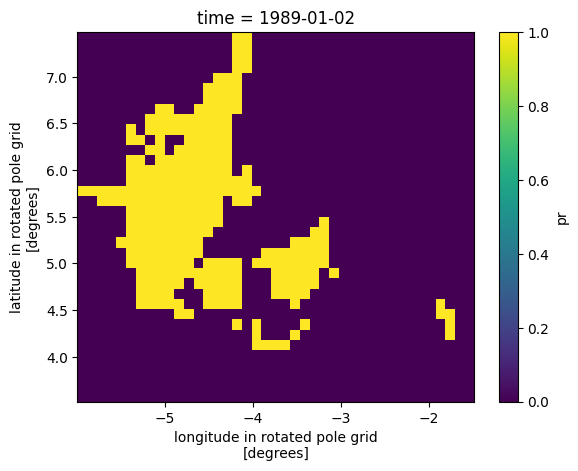

In [18]:
mask.pr.plot()

In [19]:
model_daily

<xarray.Dataset> Size: 388MB
Dimensions:       (time: 16436, rlat: 36, rlon: 41, bnds: 2)
Coordinates:
  * rlat          (rlat) float64 288B 3.575 3.685 3.795 ... 7.205 7.315 7.425
  * rlon          (rlon) float64 328B -5.935 -5.825 -5.715 ... -1.645 -1.535
  * time          (time) datetime64[ns] 131kB 1981-01-01 ... 2025-12-31
    lat           (rlat, rlon) float64 12kB 53.92 53.93 53.95 ... 58.14 58.15
    lon           (rlat, rlon) float64 12kB 7.908 8.092 8.277 ... 14.91 15.12
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, rlat, rlon, bnds) float32 194MB 0.1859 0.1859 ... 0.0
    rotated_pole  (time, rlat, rlon) float32 97MB 0.1859 0.1513 ... 0.0 0.0
    pr            (time, rlat, rlon) float32 97MB nan nan nan ... nan nan nan

In [20]:
model_calib = model_daily.sel(time=slice("1989-01-02", "2019-12-31"))['pr']
obs_calib = observations['pr']
model_bc = model_daily['pr']

In [21]:
model_calib.max()

<xarray.DataArray 'pr' ()> Size: 8B
array(112.49393463)

In [22]:
model_calib.attrs['units'] = 'mm/day'
obs_calib.attrs['units'] = 'mm/day'
model_bc.attrs['units'] = 'mm/day'

In [81]:
qdm = sdba.QuantileDeltaMapping.train(ref=obs_calib, hist=model_calib, group = 'time')
corrected_qdm = qdm.adjust(model_calib)

C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xclim\sdba\utils.py:365: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


In [82]:
# Define the ExtremeValues correction method
extremes = sdba.ExtremeValues.train(ref=obs_calib, hist=model_calib,q_thresh=0.95, cluster_thresh = "7.5 mm/day")

# Train the model with the reference (obs_calib) and historical model data (model_calib)
corrected_with_extremes = extremes.adjust(sim =model_calib, scen = corrected_qdm)

C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\xclim\sdba\utils.py:365: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


In [83]:
#Adjust wet day / dry day frequency

#corrected_qq_extr_wddd= sdba.processing.adapt_freq(ref = obs_calib, sim= corrected_with_extremes , thresh= '0.1 mm/day' , group ='time')

In [84]:
corrected_with_extremes.values[corrected_with_extremes.values <= 0.3] = 0

In [85]:
corrected_with_extremes

<xarray.DataArray 'scen' (rlat: 36, time: 11321, rlon: 41)> Size: 134MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * rlon     (rlon) float64 328B -5.935 -5.825 -5.715 ... -1.755 -1.645 -1.535
  * rlat     (rlat) float64 288B 3.575 3.685 3.795 3.905 ... 7.205 7.315 7.425
  * time     (time) datetime64[ns] 91kB 1989-01-02 1989-01-03 ... 2019-12-31
    lon      (rlat, rlon) float64 12kB 7.908 8.092 8.277 ... 14.7 14.91 15.12
    lat      (rlat, rlon) float64 12kB 53.92 53.93 53.95 ... 58.14 58.14 58.15
Attributes:
    units:            mm/day
    history:          [2025-02-26 17:16:52] : Bias-adjusted with ExtremeValue...
    bias_adjustment:  ExtremeValues(cluster_thresh=7.5).adjust(sim, scen=scen)

In [86]:
corrected_with_extremes = corrected_with_extremes.transpose("time", "rlat", "rlon")

In [87]:
corrected_with_extremes = corrected_with_extremes.rename("pr")

In [88]:
corrected_with_extremes

<xarray.DataArray 'pr' (time: 11321, rlat: 36, rlon: 41)> Size: 134MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * rlon     (rlon) float64 328B -5.935 -5.825 -5.715 ... -1.755 -1.645 -1.535
  * rlat     (rlat) float64 288B 3.575 3.685 3.795 3.905 ... 7.205 7.315 7.425
  * time     (time) datetime64[ns] 91kB 1989-01-02 1989-01-03 ... 2019-12-31
    lon      (rlat, rlon) float64 12kB 7.908 8.092 8.277 ... 14.7 14.91 15.12
    lat      (rlat, rlon) float64 12kB 53.92 53.93 53.95 ... 58.14 58.14 58.15
Attributes:
    units:            mm/day
    history:          [2025-02-26 17:16:52] : Bias-adjusted with ExtremeValue...
    bias_adjustment:  ExtremeValues(cluster_thresh=7.5).adjust(sim, scen=scen)

In [89]:
#corrected_with_extremes.to_netcdf("O:\\Man\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX DK Domain\\pr_bc\\test.nc")

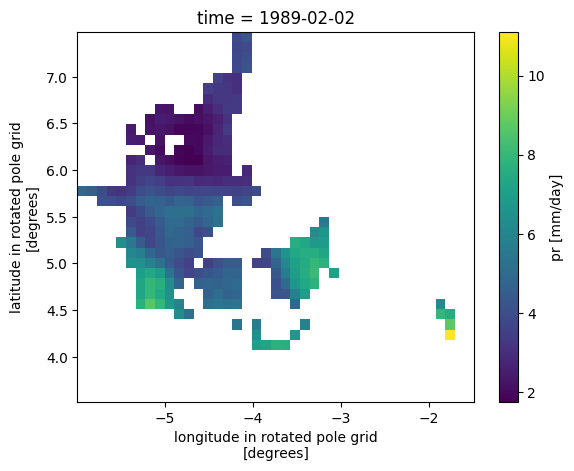

In [90]:
corrected_with_extremes.sel(time="1989-02-02").plot()

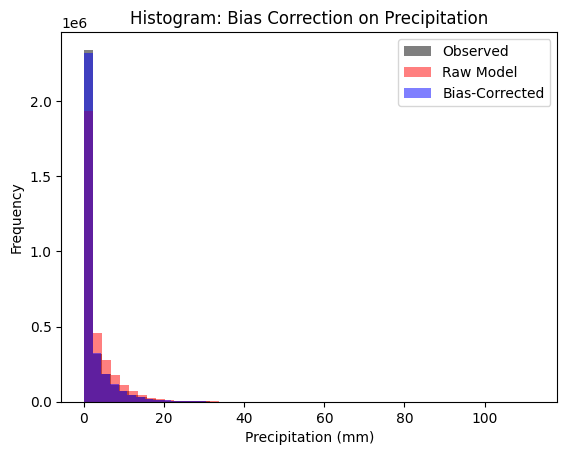

In [91]:
import matplotlib.pyplot as plt

plt.hist(obs_calib.values.flatten(), bins=50, alpha=0.5, label="Observed", color="black")
plt.hist(model_calib.values.flatten(), bins=50, alpha=0.5, label="Raw Model", color="red")
plt.hist(corrected_with_extremes.values.flatten(), bins=50, alpha=0.5, label="Bias-Corrected", color="blue")


plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Histogram: Bias Correction on Precipitation")
plt.show()


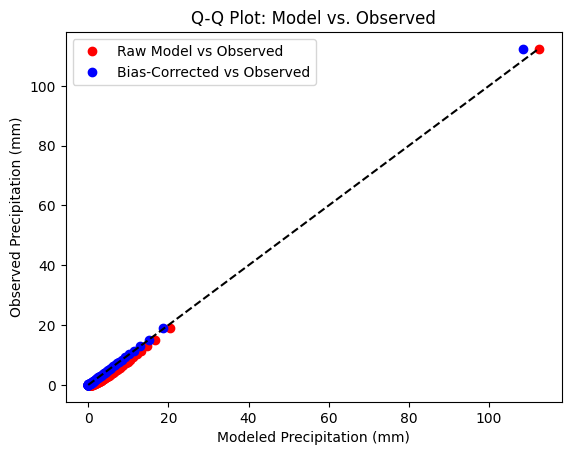

In [92]:
import scipy.stats as stats
import numpy as np

# Flatten DataArrays to 1D NumPy arrays
model_q = np.nanquantile(model_calib.values.flatten(), np.linspace(0, 1, 100))
corrected_q = np.nanquantile(corrected_with_extremes.values.flatten(), np.linspace(0, 1, 100))
obs_q = np.nanquantile(obs_calib.values.flatten(), np.linspace(0, 1, 100))

# Plot Q-Q comparison
plt.plot(model_q, obs_q, "ro", label="Raw Model vs Observed")
plt.plot(corrected_q, obs_q, "bo", label="Bias-Corrected vs Observed")
plt.plot([min(obs_q), max(obs_q)], [min(obs_q), max(obs_q)], "k--")  # 1:1 line

plt.xlabel("Modeled Precipitation (mm)")
plt.ylabel("Observed Precipitation (mm)")
plt.legend()
plt.title("Q-Q Plot: Model vs. Observed"),
plt.show()

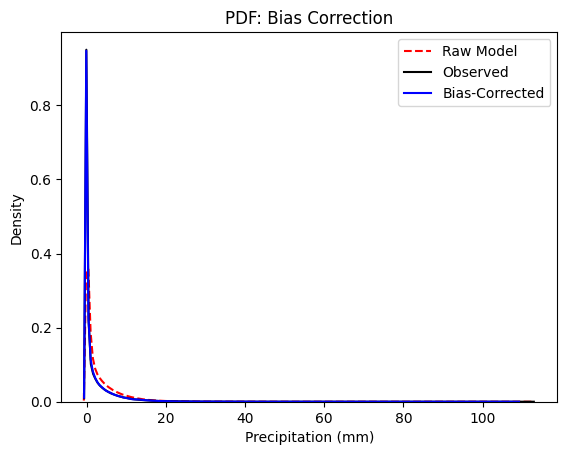

In [93]:
import seaborn as sns

sns.kdeplot(model_calib.values.flatten(), label="Raw Model", color="red", linestyle ="dashed")
sns.kdeplot(obs_calib.values.flatten(), label="Observed", color="black")
sns.kdeplot(corrected_with_extremes.values.flatten(), label="Bias-Corrected", color="blue")

plt.xlabel("Precipitation (mm)")
plt.ylabel("Density")
plt.legend()
plt.title("PDF: Bias Correction")
plt.show()

C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\mnew\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


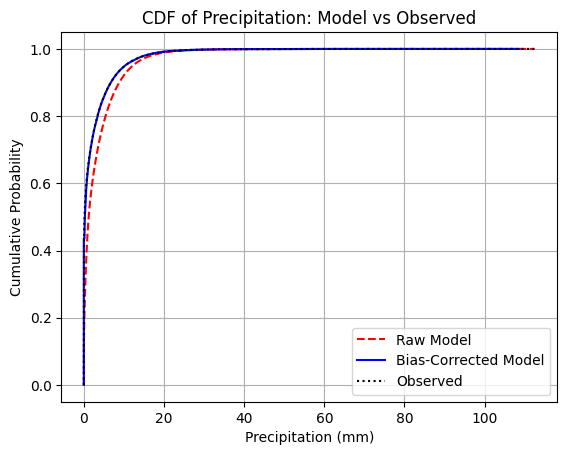

In [32]:
# Flatten DataArrays to 1D NumPy arrays (removing NaNs)
model_values = model_calib.values.flatten()
corrected_values = corrected_with_extremes.values.flatten()
obs_values = obs_calib.values.flatten()

# Remove NaNs (if any)
model_values = model_values[~np.isnan(model_values)]
corrected_values = corrected_values[~np.isnan(corrected_values)]
obs_values = obs_values[~np.isnan(obs_values)]

# Compute CDFs
sorted_model = np.sort(model_values)
sorted_corrected = np.sort(corrected_values)
sorted_obs = np.sort(obs_values)

cdf_model = np.linspace(0, 1, len(sorted_model))
cdf_corrected = np.linspace(0, 1, len(sorted_corrected))
cdf_obs = np.linspace(0, 1, len(sorted_obs))

# Plot CDFs
plt.plot(sorted_model, cdf_model, label="Raw Model", linestyle="dashed", color="red")
plt.plot(sorted_corrected, cdf_corrected, label="Bias-Corrected Model", linestyle="solid", color="blue")
plt.plot(sorted_obs, cdf_obs, label="Observed", linestyle="dotted", color="black")

# Labels and legend
plt.xlabel("Precipitation (mm)")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Precipitation: Model vs Observed")
plt.legend()
plt.grid()